In [239]:
import os.path
import sys
import tqdm # task bar
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib notebook
import idx2numpy as inp
import scipy.sparse.linalg
import scipy.spatial.distance as dist

# Loads Database

In [2]:
# also vectorises each 28 x 28 pixel image to a 784-element vector
TrImgs = np.array([img.flatten() for img in inp.convert_from_file('train-images.idx3-ubyte')])
TrLbls = inp.convert_from_file('train-labels.idx1-ubyte')
TsImgs = np.array([img.flatten() for img in inp.convert_from_file('t10k-images.idx3-ubyte')])
TsLbls = inp.convert_from_file('t10k-labels.idx1-ubyte')
# calculate TRAINING IMGS mean for use in rest of program
TrImgsMean = (np.mean(TrImgs,axis=0))

## Simple Tools

In [3]:
show = lambda img: plt.imshow(img.reshape(28,28)) # show vectorised alphabet

# Class Means & Between-Class Scatter

In [4]:
def ClassMeans(Imgs,Lbls):
    """Returns rows of class-means"""
    class_means = []
    classes = np.unique(Lbls) # get unique labels, sorted
    for c in classes:
        sys.stdout.write("\rDoing class %d" % c); sys.stdout.flush()
        class_imgs = Imgs[Lbls==c] # get set of class images
        class_means.append(np.mean(class_imgs,axis=0)) 
    print("\n")
    return np.array(class_means).astype('float16')

In [5]:
# Test Area!
v = np.array([[1,0]]).T
print v
print np.dot(v,v.T)
print np.outer(v,v)

[[1]
 [0]]
[[1 0]
 [0 0]]
[[1 0]
 [0 0]]


In [6]:
def Sb(Imgs,Lbls):
    """Between-Class scatter matrix"""
    Mean = np.mean(Imgs,axis=0)
    Means = ClassMeans(Imgs,Lbls)
    N = len(Lbls)
    
    classes = np.unique(Lbls) # get unique class labels, sorted
    C = len(classes)
    class_nums = np.array([np.sum(Lbls==c) for c in classes]) # compute class size
    class_frac = class_nums*1./N # class fraction
    
    Sb = np.zeros(shape=(784,784))
    
    for c in classes:
        vec = np.array([Means[c]-Mean]).T # centred class mean expressed as a column vector
        Sb += class_frac[c]*np.dot(vec,vec.T) # column * row = matrix !
    return Sb

In [259]:
TrSb = Sb(TrImgs,TrLbls)

Doing class 9



# Class Covariances & Within-Class Scatter

In [166]:
def ClassCovars(Imgs,Lbls):
    """Returns rows of class-covars"""
    classes = np.unique(Lbls)  # get unique class labels, sorted
    C = len(classes)
    d = 784
    Covs = np.zeros(shape=(C,d,d))
    Vars = np.zeros(C)
    for c in classes:
        sys.stdout.write("\rDoing class %d" % c); sys.stdout.flush()
        class_imgs = Imgs[Lbls==c] # get set of class images
        class_mean = np.mean(class_imgs,axis=0)
        n = len(class_imgs)
        for i, img in enumerate(class_imgs):
            sys.stdout.write("\rDoing class {} img {} of {}\t".format(c,i,n)); sys.stdout.flush()
            vec = img[:d]-class_mean[:d]
            Vars[c] += np.inner(vec,vec)
            Covs[c] += np.outer(vec,vec)
        Covs[c] = Covs[c]*1./n # normalise to number of images in class
#         print "determinant = {} \t trace = {} \t variance = {} \n covar={}"\
#         .format(np.linalg.det(Covs[c]),
#                np.trace(Covs[c]),
#                Vars[c],
#                np.nonzero(Covs[c])) #sanity check
        print("\n")
    print("\n")
    return np.array(Covs)

In [168]:
if os.path.exists('TrClassCovs.npy'):
     TrCovars = np.load('TrClassCovs.npy')
else:
    TrCovars = ClassCovars(TrImgs,TrLbls)
    np.save('TrClassCovs',TrCovars)

In [175]:
def Sw(Lbls, ClassCovariances):
    """Returns Within-Class scatter matrix"""
    """
    :params ClassCovariances: a list of matrices, each the covariance matrix of the class
    :note: going from ClassCovars to Sw seem to be a bit of an extra step 
    - one could certainly do it all in a single step, but I wanted to break the step in to little parts,
    and save the ClassCovariances since it takes a large chunk of processing time...
    """
    classes = np.unique(Lbls)  # get unique class labels, sorted
    C = len(classes)
    N = len(Lbls)
    Sw = np.zeros(shape = (784,784))
    for c in classes:
        class_nums = np.sum(Lbls==c) # number of images in class
        class_frac = class_nums*1./N
        Sw += class_frac * ClassCovariances[c]
#         Sw += ClassCovariances[c]*1./N
    return np.array(Sw)

In [73]:
TrSw = Sw(TrLbls,TrCovars)

In [174]:
# check if tr covar output makes sense by comparing trce of covar matrix with variance...
print np.trace(TrCovars[0])
imgs0 = TrImgs[TrLbls==0]
imgs0mean = np.mean(imgs0,axis=0)
var=0
for img in imgs0:
    v = img-imgs0mean
    var += np.inner(v,v)
print var/len(imgs0)

3245975.63883
3245975.63883


# Remove subspaces with no information

In [12]:
def NonZeroIndices(m,flip=False):
    """
    identifies subspace of m containing no information
    returns indices of this space
    """
    n = len(m[0])
    original_indices = np.arange(n)
    zero_idxs = np.array([i for i, row in enumerate(m) if np.any(row)==False])
    nonzero_idxs = np.array(list(set(original_indices)-set(zero_idxs)))
    
    if flip:
        return zero_idxs
    else:
        return nonzero_idxs

In [13]:
def ReduceM(m):
    """
    assumes m is a n x n square matrix
    removes subspace corresponding to indices from m
    """
    nonzero_indices = NonZeroIndices(m)
    return np.array([m[i][nonzero_indices] for i in nonzero_indices])

## Check if reduced matrices of Sb and Sw are the same dimensions

In [14]:
ReduceM(TrSb).shape==ReduceM(TrSw).shape

True

In [256]:
len(np.linalg.eigvals(ReduceM(TrSb)))

717

# Get eigenvalues and eigenvectors

In [262]:
# Get eigenvectors and eigenvalues
def lda(Sb,Sw):
    """
    LDA: 
    1.Returns eigenvectors and eigenvalues in sorted order of eigenvalues.
    """
    EVals, EVecs = np.linalg.eig(np.dot(np.linalg.inv(ReduceM(TrSw)),ReduceM(TrSb)))
    EValsSorted = np.flipud(np.sort(np.real(EVals))) # sorts eigenvalues in descending order
    EVecsSorted = np.real(EVecs[np.flipud(np.argsort(np.real(EVals)))]) # sorts eigenvectors in the same order as EValsSorted
    return EValsSorted, EVecsSorted

In [263]:
# if os.path.exists('lda_training_eigenvalues.npy') and os.path.exists('lda_training_eigenvectors.npy'):
#     TrD = np.load('lda_training_eigenvalues.npy')
#     TrU = np.load('lda_training_eigenvectors.npy') 
# else:
TrD, TrU = lda(TrSb,TrSw)
#     np.save('lda_training_eigenvalues',TrD)
#     np.save('lda_training_eigenvectors',TrCovars)

<IPython.core.display.Javascript object>


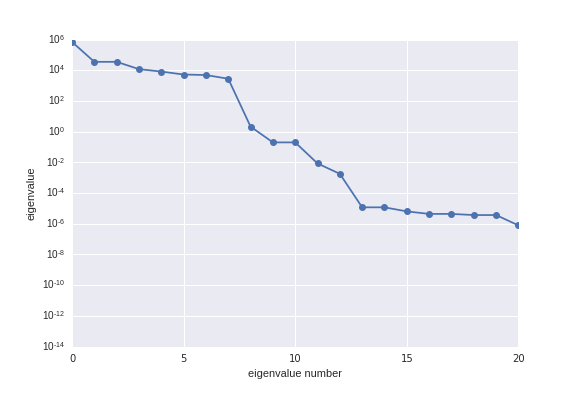

[]

In [279]:
plt.figure()
plt.xlabel('eigenvalue number')
plt.ylabel('eigenvalue')
plt.plot(TrD,marker='o')
plt.xlim(0,20)
# plt.ylim(1e-2,)
plt.semilogy()

# Reduced Components

In [183]:
mask=NonZeroIndices(TrSw)
def ReducedI(Imgs,mask):
    """returns list of images of reduced dimensionality"""
    return np.array([img[mask] for img in Imgs])
def Comps(Imgs, u, p):
    """
    Components in Reduced Dimensions:
    1. picks up p columns of u as a reduced basis set.
    2. returns the component sizes
    
    :params p: reduced dimension to output
    """
#     uCols = u[:p] #  transpose to get columns, use the first p columns
#     return np.dot(uCols,Imgs.T)
    return np.array([[np.inner(u[i],img) for i in np.arange(p)] for img in Imgs])

In [220]:
Imgs2Comps = Comps(ReducedI(TrImgs,mask),TrU,2).T
Imgs3Comps = Comps(ReducedI(TrImgs,mask),TrU,3).T

In [192]:
cmeans = ClassMeans(TrImgs,TrLbls)
cmeansred = [x[mask] for x in cmeans]
meanys = Comps(cmeansred,TrU,2).T
meanys3 = Comps(cmeansred,TrU,3).T

Doing class 9



## 2-component visualisation

<IPython.core.display.Javascript object>


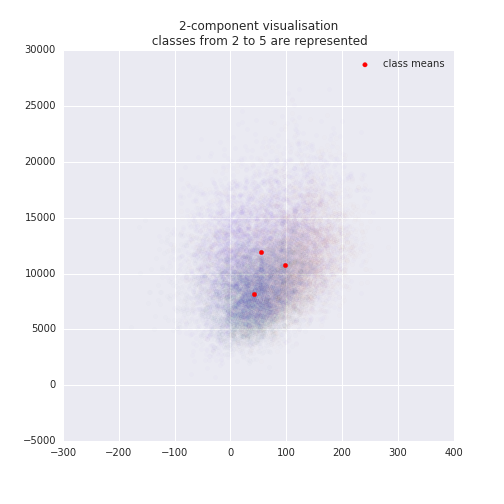

In [253]:
(j,k) = (2,5) #class range to sketch for
plt.figure(figsize=(7,7))
plt.title('2-component visualisation\n classes from {} to {} are represented'.format(j,k))
[plt.scatter(Imgs2Comps[0][TrLbls==c],Imgs2Comps[1][TrLbls==c],
             alpha=0.01,
             marker='o',
             c=np.random.rand(4,),
#              label=c
            ) 
 for c in np.unique(TrLbls)[j:k]]

plt.scatter(meanys[0][j:k],meanys[1][j:k],alpha=1,color='red',label='class means')
plt.legend()

# 3-component visualisation

<IPython.core.display.Javascript object>


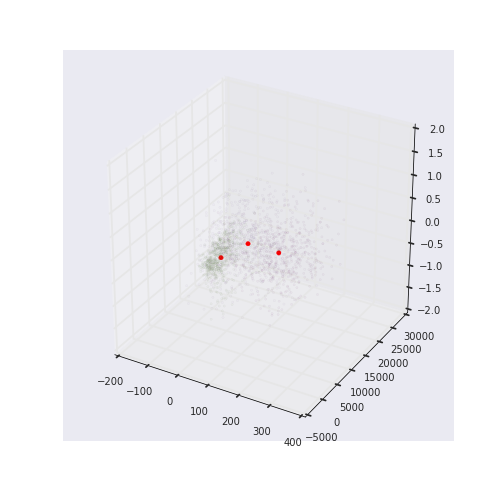

In [254]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
j = 3
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
[ax.scatter(Imgs3Comps[0][TrLbls==c][::10],
            Imgs3Comps[1][TrLbls==c][::10],
            Imgs3Comps[2][TrLbls==c][::10],
            marker='.',alpha=0.05,c=np.random.rand(4,4))
 for c in np.unique(TrLbls)[:j]
]
ax.scatter(meanys3[0][:j],meanys3[1][:j],meanys3[2][:j],alpha=1,color='red')
# ax.set_xlim(np.min(Imgs3Comps[0]),np.max(Imgs3Comps[0]))
# ax.set_ylim(np.min(Imgs3Comps[1]),np.max(Imgs3Comps[1]))
# ax.set_zlim(np.min(Imgs3Comps[2]),np.max(Imgs3Comps[2]))
plt.show()